In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

In [ ]:
"""Tetapan yang digunakan"""
hbar   = 1.054571817e-34     #Js
kB     = 1.3806504e-23       #JK-1
me     = 9.109534e-31        #Kg
e      = 1.602176487e-19     #C
eVJ    = 1.602176634e-19     #Merubah eV menjadi Joule
JeV    = 6.241506363e18      #Merubah Joule ke eV

In [ ]:
""""Faktor konversi untuk satuan bilangan gelombang"""
m_nm  = 1e-18                #agar satuan k menjadi nm-1
s     = 2*me*eVJ*m_nm/(hbar**2)

#Model

In [ ]:
"""Massa Efektif, Energi Gap, dan Pergeseran pita konduksi"""
def m_AlGaAs(z):
  nilai_massa = 0.067 + 0.083*z
  #Massa efektif memiliki satuan me
  return nilai_massa

def E0_AlGaAs(z, T):
  A        = (5.4/(T+204) - 6/(T+408)) * 1e-4 * T**2 * z
  B        = (5.4 * 1e-4/(T+204)) * T**2
  nilai_E0 = 1.519 + 1.452*z + A - B - 0.732*z**2
  #Satuan dalam eV
  return nilai_E0

def pergeseran(z):
  if 0 <= z < 0.45:
    U0 = 0.6 * 1.247 * z
  else:
    U0 = 0.6 * (1.247 * z + 1.147 * (z-0.45)**2)
  #Satuan dalam eV
  return U0

""""Menghitung Energi Fermi daerah terdoping"""
def EnergiFermi(doping, lebardoping, T, E0, m_W):
  nd = doping/1e-6          #satuan dalam m-3
  ld = lebardoping * 1e-9   #satuan dalam m

  #Menghitung Energi Fermi pada 0 K
  EF0 = np.pi * hbar**2 * nd * ld / (m_W*me)
  EF0 = EF0 + E0*eVJ

  #Menghitung Energi Fermi pada T K
  Efm = EF0 * (1 - (1/12)*(np.pi * kB * T /EF0)**2)
  Efm = Efm * JeV
  return Efm

"""Pembagian Massa Efektif terhadap struktur yang digunakan"""
def massa_efektif(x, L0, LE, LB, LW, LC, m_B, m_W):
  if L0 + LE <= x <= L0 + LE + LB:
    m = m_B
  elif L0 + LE + LB + LW <= x <= L0 + LE + LB + LW + LB :
    m =  m_B
  else:
    m = m_W
  #Massa efektif memiliki satuan me
  return m

"""Pembagian Potensial terhadap struktur yang digunakan"""
def potensial(x, LB, Vbias, E0, U0, L0, LE, LW, LC):
  L = LE + 2*LB + LW + LC
  if 0 <= x < L0:
    potensial = E0
  elif L0 <= x < L0 + LE:
    potensial = E0 - Vbias * (x-L0)/ L
  elif L0 + LE <= x <= L0 + LE + LB:
    potensial = E0 + U0 - Vbias * (x-L0)/ L
  elif L0 + LE + LB < x < L0 + LE + LB + LW:
    potensial = E0 - Vbias * (x-L0)/ L
  elif L0 + LE + LB + LW <= x <= L0 + LE + 2*LB + LW:
    potensial = E0 + U0 - Vbias * (x-L0)/ L
  elif L0 + LE + 2*LB + LW < x < L0 + L:
    potensial = E0 - Vbias * (x-L0)/ L
  else:
    potensial = E0 - Vbias
  return potensial

In [ ]:
"""Menentukan nilai parameter tetap"""
def param():
  z   = 0.3  #fraksi Al(z)Ga(z-1)As

  #massa efektif elektron pada barrier Al(z)Ga(z-1)As dalam satuan me
  m_B = m_AlGaAs(z)

  #massa efektif elektron pada GaAs dalam satuan me
  m_W = m_AlGaAs(0)

  #U0 adalah pergeseran pita konduksi GaAs dan Al(z)Ga(z-1)As
  U0 = pergeseran(z)

  #Konsentrasi doping
  nd = 1e18  #cm-3

  #Ukuran
  L0, LE, LW, LC = 10, 2.5, 4.5, 2.5  #nm

  #Perubahan-data
  dx = 0.01 #nm
  dE = 0.001 #eV
  dV = 0.002 #Volt

  return z, m_B, m_W, U0, nd, L0, LE, LW, LC, dx, dE, dV

#Metode Matriks Transfer T(E)

In [ ]:
"""Beberapa fungsi untuk metode Matriks Transfer"""

"""Bilangan gelombang"""
@njit
def km(E, Vm, mfm):
  #Atasi nilai k=0 untuk E=V
  if E == Vm:
    Ec = E + 1e-15
    k  = np.sqrt(s*mfm*(Ec-Vm) + 0j)
  else:
    k  = np.sqrt(s*mfm*(E-Vm) + 0j)
  return k

"""Koefisien delta"""
@njit
def delta(E, Vm, mfm, Vm1, mfm1):
  k0 = km(E, Vm, mfm)
  k1 = km(E, Vm1, mfm1)
  delta1 = (k1/k0)*(mfm/mfm1)
  return delta1

"""Matriks Syarat Batas (D)"""
@njit
def D(E, Vm, mfm, Vm1, mfm1):
  delta1 = delta(E, Vm, mfm, Vm1, mfm1)
  a = 0.5*(1 + delta1)
  b = 0.5*(1 - delta1)
  c = b
  d = a
  nilai_D = np.array([[a, b], [c, d]])
  return nilai_D

"""Matriks Propagasi (P)"""
@njit
def P(E, Vm, mfm, dm):
  a = np.exp(-1j * km(E, Vm, mfm) * dm)
  b = 0
  c = 0
  d = np.exp( 1j * km(E, Vm, mfm) * dm)
  nilai_P = np.array([[a, b], [c, d]])
  return nilai_P

In [ ]:
"""Perhitungan Koefisien Transmisi """
@njit
def nilai(E, pot, mass_eff, Nx, dxi):
  M = np.identity(2, dtype=np.complex128)

  #Matriks Syarat Batas Awal
  M = M @ D(E, pot[0], mass_eff[0], pot[1], mass_eff[1])

  for i in range(1, Nx-1):
    matriks_P = P(E, pot[i], mass_eff[i], dxi[i])
    matriks_D = D(E, pot[i], mass_eff[i], pot[i+1], mass_eff[i+1])
    M= M @ matriks_P @ matriks_D

  #Nilai koefisien trasmisi
  A = np.abs(M[0,0])
  B = np.abs(M[1,0])
  rasio_meff = mass_eff[0]/mass_eff[-1]
  kR   = km(E, pot[-1], mass_eff[-1])
  kL   = km(E, pot[0], mass_eff[0])
  rasio_koef = (np.abs(kR))/(np.abs(kL))
  T = rasio_meff * rasio_koef / (A*A)

  return T

#Persamaan S(E), J(E), dan Perhitungan



In [ ]:
@njit
def koef_S(Ex, Vbias, Efm, T):
  """Perhitungan dilakukan dalam satuan SI"""
  Em  = 1 + np.exp((Efm-Ex)*eVJ/(kB*T))
  Co  = 1 + np.exp((Efm-Ex-Vbias)*eVJ/(kB*T))
  SX  = np.log(Em/Co)

  return SX

In [ ]:
"""
Rapat arus disini hanya dihitung bagian integralnya,
untuk koefisien didepan langsung dikalikan pada array hasilnya
"""
@njit
def rapat_arus(nilai_transmisi, nilai_S, NE, dE):
  """Perhitungan integral rectangular dilakukan dalam satuan SI """
  B = 0
  for i in range(NE):
    C = nilai_transmisi[i] * nilai_S[i] * dE * eVJ
    B = B + C
  J = B

  return J

In [ ]:
"""Perhitungan Kerapatan Arus untuk LB dan T tertentu"""

def perhitungan(LB, T):

  z, m_B, m_W, U0, nd, L0, LE, LW, LC, dx1, dE, dV = param()

  """Membuat pembagian daerah sumbu x"""
  aktif_min = L0
  aktif_max = L0 + LE + 2*LB + LW + LC
  x1 = np.arange(0, aktif_min - dx1, 5)                   #Daerah terdoping
  x2 = np.arange(aktif_min - dx1, aktif_max, dx1)         #Daerah aktif
  x3 = np.arange(aktif_max, aktif_max + L0 + 1e-4, 5)     #Daerah terdoping
  x = np.concatenate((x1, x2, x3))
  dx = np.diff(x)
  Nx = len(x)

  """Membuat pembagian massa efektif"""
  mass_eff = np.array([massa_efektif(A, L0, LE, LB, LW, LC, m_B, m_W) for A in x])

  """E0 dan Energi Fermi pada T K dalam eV"""
  E0    = E0_AlGaAs(0, T)       #E0 adalah energi minimal pita konduksi GaAs
  Efm   = EnergiFermi(nd, L0, T, E0, m_W)

  """Persebaran Energi elektron (eV)"""
  Emin  = E0                   #Energi minimal pita konduksi
  Emax  = Efm + 10*kB*T *JeV   #Batas perkiraaan cutoff energi
  NE    = int((Emax - Emin)/dE) + 1
  E     = np.linspace(Emin, Emax, NE)

  #Data arus, koefisien transmisi, dan V(x) pada Vbias tertentu
  J     = []
  trans = []
  poten = []

  print(f"Barrier Width : {LB}, Temperatur : {T}")

  """Perulangan perhitungan untuk Vbias"""
  #Tegangan bias yang disimulasikan
  biasmin = 0
  biasmax = 0.5
  Vb      = np.arange(biasmin, biasmax + dV/10, dV)

  i = 0

  for Vbias in Vb:
    pot             = np.array([potensial(B, LB, Vbias, E0, U0, L0, LE, LW, LC) for B in x])
    nilai_transmisi = [nilai(C, pot, mass_eff, Nx, dx) for C in E]
    nilai_S         = koef_S(E, Vbias, Efm, T)
    kerapatan_arus  = rapat_arus(nilai_transmisi, nilai_S, NE, dE)

    trans.append(nilai_transmisi)
    poten.append(pot)
    J.append(kerapatan_arus)

    if i%25 == 0:
       print(f"Vbias = {Vbias} Volt")
    i += 1

  J       = np.array(J)
  const_J = m_W*me*e*kB*T / (2*(np.pi**2)*hbar**3)
  J       = J*const_J
  trans   = np.array(trans)
  poten   = np.array(poten)

  return x, E, Efm, poten, trans, Vb, J

#Simulasi dan Simpan Data

In [ ]:
"""Masukan LB dan T yang akan dilakukan simulasi"""
LB            = [2]
Temperature   = [300]

for i in LB:
  for j in Temperature:
    x, E, Efm, pot, nilai_transmisi, Vb, J = perhitungan(i, j)

    #save npz
    filename = f"data_LB{i}_T{j}.npz"
    np.savez(filename, x=x, Vbias=Vb, E=E, Ef=Efm, pot=pot, nilai_transmisi=nilai_transmisi, J=J)

Barrier Width : 2, Temperatur : 300
Vbias = 0.0 Volt
Vbias = 0.05 Volt
Vbias = 0.1 Volt
Vbias = 0.15 Volt
Vbias = 0.2 Volt
Vbias = 0.25 Volt
Vbias = 0.3 Volt
Vbias = 0.35000000000000003 Volt
Vbias = 0.4 Volt
Vbias = 0.45 Volt
Vbias = 0.5 Volt


#Plot

In [ ]:
LB_test   = 2
T_test   = 300
filename = f"data_LB{LB_test}_T{T_test}.npz"
data = np.load(filename)

x = data['x']
Vb = data['Vbias']
Ef = data['Ef']
E = data['E']
pot = data['pot']
nilai_transmisi = data['nilai_transmisi']
J = data['J']

In [ ]:
print(Ef, E[0])

1.4579228632433578 1.4225714285714284


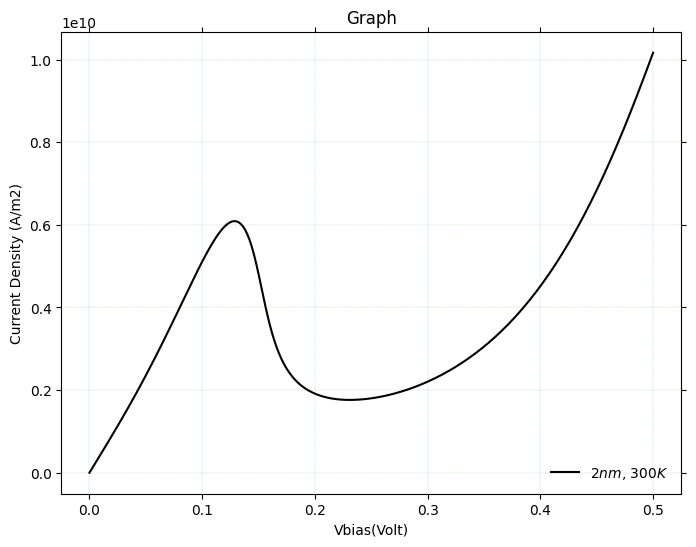

In [ ]:
#Plot
plt.figure(figsize=(8, 6))
plt.plot(Vb, J, color='black', label=f'${LB_test} nm$, ${T_test} K$')
plt.title(f"Graph")
plt.xlabel("Vbias(Volt)")
plt.ylabel("Current Density (A/m2)")
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

ax = plt.gca()
ax.tick_params(top=True, right=True, which='both')
plt.grid(color = 'green', linestyle = '-.', linewidth = 0.1)
plt.legend(labelspacing=0.2, frameon = False, loc = 'lower right')

plt.show()

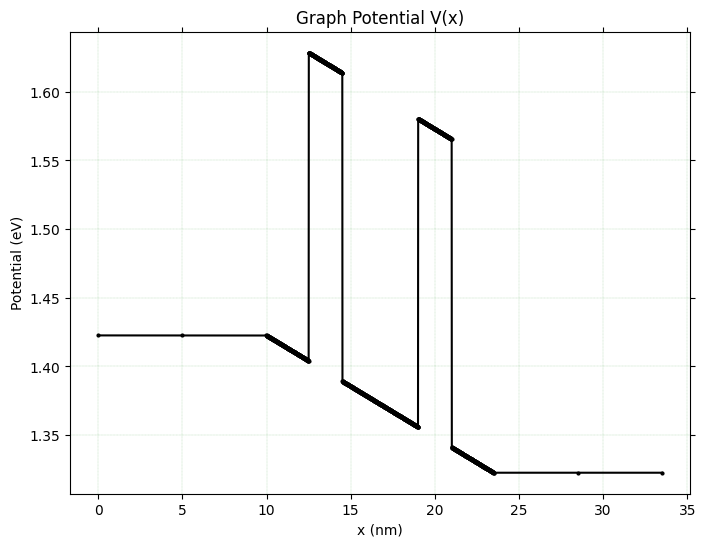

In [ ]:
#Plot bentuk potensial
nplot = 50

plt.figure(figsize=(8, 6))
plt.plot(x, pot[nplot], marker='o', ms=2, color='black')
plt.title(f"Graph Potential V(x)")
plt.xlabel("x (nm)")
plt.ylabel("Potential (eV)")

ax = plt.gca()
ax.tick_params(top=True, right=True, which='both')
plt.grid(color = 'green', linestyle = '-.', linewidth = 0.1)
plt.show()

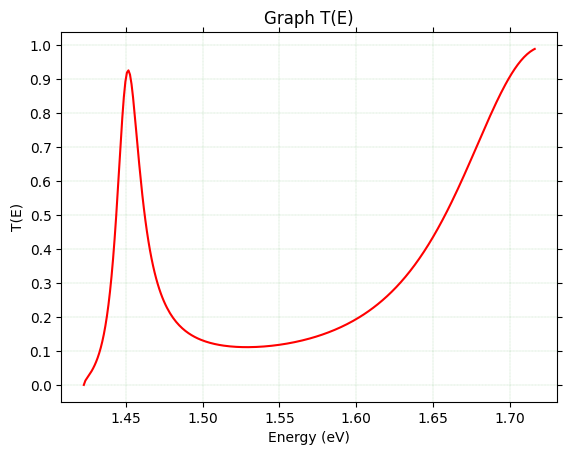

In [ ]:
plt.plot(E, nilai_transmisi[nplot], color='red')
plt.title("Graph T(E)")
#plt.xticks(np.arange(1.42, 1.605 + 0.02, 0.02))
plt.yticks(np.arange(0, 1 + 0.1, 0.1))
plt.xlabel("Energy (eV)")
plt.ylabel("T(E)")

ax = plt.gca()
ax.tick_params(top=True, right=True, which='both')
plt.grid(color = 'green', linestyle = '-.', linewidth = 0.1)
#plt.legend(labelspacing=0.2, frameon = False, loc = 'lower right')

plt.show()